<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Reconocimiento de Formas, 2024 - 2025 </b></div>

## **Clasificación de Animales: Ajuste de learning rate y batch size**

In [1]:
!pip install keras_tuner --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import keras_tuner
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
keras.utils.set_random_seed(23)

Realizamos la lectura de los datos.

In [3]:
dataset_path = '/kaggle/input/animals10/raw-img'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_clases = 10

train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

test_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

validation_split = 0.25  
num_validation_batches = int(validation_split * len(train_dataset)) #.file_paths
validation_dataset = train_dataset.take(num_validation_batches)
train_dataset = train_dataset.skip(num_validation_batches)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Definimos el espacio de busqueda para el keras tuner y realizamos las pruebas.

In [4]:
class MyHyperModel(keras_tuner.HyperModel):

  def build(self, hp):
      M = keras.Sequential()
      M.add(keras.Input(shape=(64,64,3)))
      M.add(keras.layers.Rescaling(scale = 1/255))
      M.add(keras.layers.Flatten())
      M.add(keras.layers.Dense(units=4096, activation='relu'))
      M.add(keras.layers.Dense(units=256, activation='relu'))
      M.add(keras.layers.Dense(units=64, activation='relu'))
      M.add(keras.layers.Dense(10, activation='softmax'))
      learning_rate = hp.Float("lr", min_value=0.0005, max_value=0.0015)
      opt = keras.optimizers.Adam(learning_rate=learning_rate)
      M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])
      return M


  def fit(self, hp, M, xy, xy_val, **kwargs):
      bs = hp.Int("batch_size", 64, 256, step=2, sampling="log")
      early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=10, min_delta=1e-5)
      kwargs['callbacks'].append(early_cb)
      return M.fit(xy, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)


In [5]:
tuner = keras_tuner.BayesianOptimization(MyHyperModel(), 
                                         objective="val_SparseCategoricalAccuracy", 
                                         max_trials = 5, 
                                         executions_per_trial = 1,
                                         overwrite=True)

In [6]:
tuner.search(train_dataset, validation_dataset)

Trial 5 Complete [00h 11m 16s]
val_SparseCategoricalAccuracy: 0.3694401979446411

Best val_SparseCategoricalAccuracy So Far: 0.40299078822135925
Total elapsed time: 00h 37m 36s


In [7]:
tuner.results_summary(num_trials = 1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_SparseCategoricalAccuracy", direction="max")

Trial 3 summary
Hyperparameters:
lr: 0.0007048519046001057
batch_size: 256
Score: 0.40299078822135925


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

In [8]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 1.897
Precisión: 41.41%


In [9]:
M = keras.Sequential()
M.add(keras.Input(shape=(64,64,3)))
M.add(keras.layers.Rescaling(scale = 1/255))
M.add(keras.layers.Flatten())
M.add(keras.layers.Dense(units=4096, activation='relu'))
M.add(keras.layers.Dense(units=256, activation='relu'))
M.add(keras.layers.Dense(units=64, activation='relu'))
M.add(keras.layers.Dense(10, activation='softmax'))
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=learning_rate)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=10, min_delta=1e-5)
H = M.fit(train_dataset, batch_size=128, epochs=100, validation_data=validation_dataset, verbose=1, callbacks = early_cb)

Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - SparseCategoricalAccuracy: 0.1787 - loss: 4.6663 - val_SparseCategoricalAccuracy: 0.2745 - val_loss: 2.0662
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - SparseCategoricalAccuracy: 0.2605 - loss: 2.0470 - val_SparseCategoricalAccuracy: 0.2755 - val_loss: 2.0303
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - SparseCategoricalAccuracy: 0.2973 - loss: 1.9679 - val_SparseCategoricalAccuracy: 0.3033 - val_loss: 1.9553
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - SparseCategoricalAccuracy: 0.3209 - loss: 1.9112 - val_SparseCategoricalAccuracy: 0.3181 - val_loss: 1.9242
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - SparseCategoricalAccuracy: 0.3395 - loss: 1.8653 - val_SparseCategoricalAccuracy: 0.3010 - val_loss: 2.0062
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - SparseCategoricalAccuracy: 0.3492 - loss: 1.8380 - val_SparseCategoricalAccuracy: 0.3401 - val_loss: 1.8795
Epoch 7/10

In [10]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 2.251
Precisión: 37.19%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

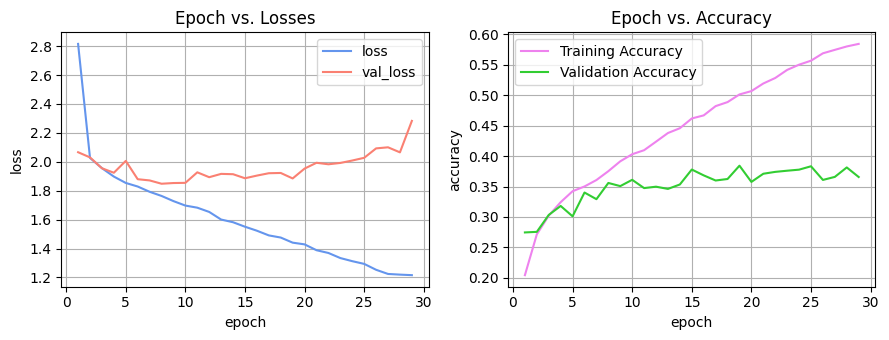

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
# ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
# ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

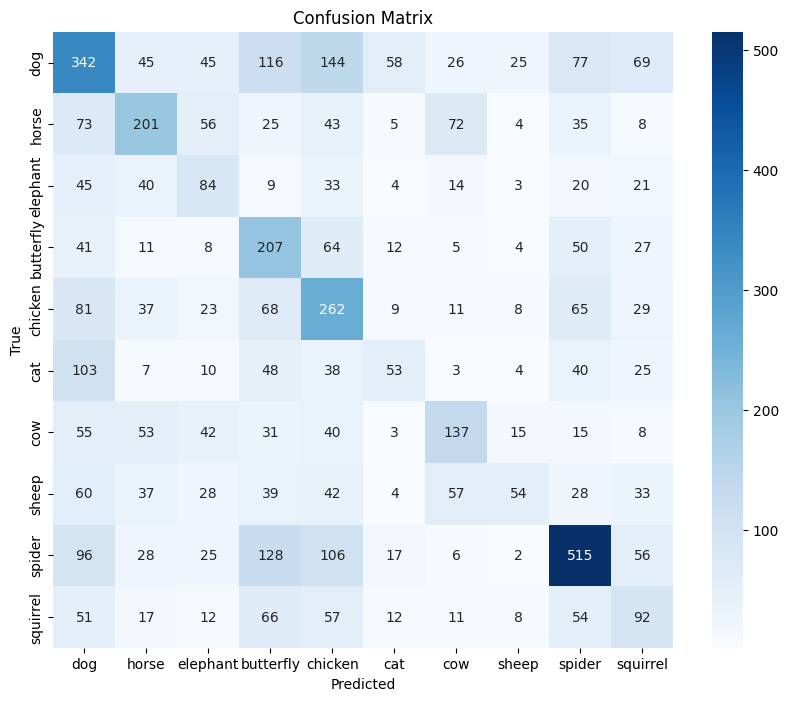

              precision    recall  f1-score   support

         dog       0.36      0.36      0.36       947
       horse       0.42      0.39      0.40       522
    elephant       0.25      0.31      0.28       273
   butterfly       0.28      0.48      0.36       429
     chicken       0.32      0.44      0.37       593
         cat       0.30      0.16      0.21       331
         cow       0.40      0.34      0.37       399
       sheep       0.43      0.14      0.21       382
      spider       0.57      0.53      0.55       979
    squirrel       0.25      0.24      0.25       380

    accuracy                           0.37      5235
   macro avg       0.36      0.34      0.33      5235
weighted avg       0.39      0.37      0.37      5235



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

## **Resumen de Resultados**

- Con el MLP sencillo obtenemos una precisión del 36.6%.
- Usando el Keras Tuner para la arquitectura de red obtenemos una precisión del 37.1%.
- Al realizar el ajuste del Learning rate y BatchSize obtenemos una precisión del 37.19%, hay una mejora con respecto al caso anterior y sube el f1-score de categorías minoritarias, es decir, el modelo esta aprendiendo a extraer caracteristicas correctamente sin dejarse sesgar del todo por las categorías mayoritarias con un learning rate de 0.001 y un batch_size de 128. 